We left off with the disturbing realization that even though we are satisfied the requirements of the sampling theorem, we still have errors in our approximating formula. We can resolve this by examining the Whittaker interpolating functions which are used to reconstruct the signal  from its samples.

Text(3.1, 0.5, '... and going...')

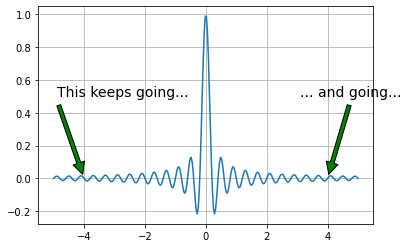

In [4]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-5,5,300) # redefine this here for convenience

fig,ax = plt.subplots()

fs = 5.0
ax.plot(t, np.sinc(fs * t))
ax.grid()
ax.annotate('This keeps going...',
            xy=(-4,0),
            xytext=(-5+.1,0.5),
            arrowprops={'facecolor':'green','shrink':0.05},fontsize=14)
ax.annotate('... and going...',
            xy=(4,0),
            xytext=(3+.1,0.5),
            arrowprops={'facecolor':'green','shrink':0.05},fontsize=14)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Notice in the above plot that the function extends to infinity in either direction. This basically means that the signals we can represent must also extend to infinity in either direction which then means that we have to sample forever to exactly reconstruct the signal! So, on the one hand the sampling theorem says we only need a sparse density of samples, this result says we need to sample forever. No free lunch here!

This is a deep consequence of dealing with band-limited functions which, as we have just demonstrated, are **not** time-limited. Now, the new question is how to get these signals into a computer with finite memory. How can we use what we have learned about the sampling theorem with these finite-duration signals?

## Approximately Time-Limited Functions

Let's back off a bit and settle for functions that are *approximately*  time-limited in the sense that almost all of their energy is concentrated in a finite time-window:

$$ \int_{-\tau}^\tau |f(t)|^2 dt = E-\epsilon$$

where $E$ is the total energy of the signal:

$$ \int_{-\infty}^\infty |f(t)|^2 dt = E$$

Now, with this new definition, we can seek out functions that are band-limited but come very, very (i.e. within $\epsilon$) close to being time-limited as well. In other words, we want functions $\phi(t)$ so that they are band-limited:

$$ \phi(t) = \int_{-W}^W \Phi(\nu) e^{2 \pi j \nu t} dt $$

and coincidentally maximize the following:

$$ \int_{-\tau}^\tau |\phi(t) |^2 dt$$

After a complicated derivation,  this boils down to solving the following eigenvalue equation:

$$ \int_{-\tau}^\tau \phi(x)\frac{\sin(2\pi W(t-x))}{\pi(t-x)} dx = \lambda \phi(t)$$

The set of $\phi_k(t)$ eigenfunctions form the basis for arbitrary
approximately time-limited functions. In other words, we can express

$$ f(t) = \sum_k a_k \phi_k(t) $$

Note that
the $\phi_k(t)$ functions are not time-limited, but only time-concentrated in the $[-\tau,\tau]$ interval. With a change of variables, we can write this in normalized form as 

$$ \int_{-1}^1 \psi(x)\frac{\sin(2\pi\sigma(t-x)/4)}{\pi(t-x)} dx = \lambda \psi(t)$$

where we define$\sigma = (2\tau)(2W)$ as the time-bandwidth product.The advantage of this change of variables is that $\tau$ and $W$ are expressed as a single term. Furthermore, this is the form of a classic problem where the $\psi$ functions turn out to be the angular prolate spheroidal wave functions. Let's see what these $\psi$ functions look like but solving this form of
the eigenvalue problem

In [16]:
def kernel(x,sigma=1):
    'convenient function to compute kernel of eigenvalue problem'
    x = np.asanyarray(x)
    y = np.pi*np.where(x == 0,1.0e-20, x)
    return np.sin(sigma/2*y)/y

Now, we are ready to setup the eigenvalues and see how they change with the time-bandwidth product.

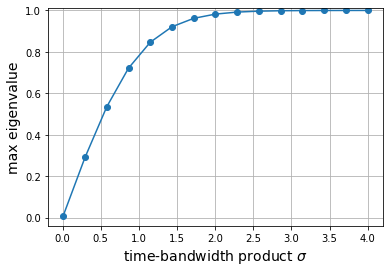

In [17]:
nstep = 100                # quick and dirty integral quantization
t = np.linspace(-1,1,nstep) # quantization of time
dt = np.diff(t)[0]          # differential step size
def eigv(sigma):
    return np.linalg.eigvalsh(kernel(t-t[:,None],sigma)).max() # compute max eigenvalue

sigma = np.linspace(0.01,4,15) # range of time-bandwidth products to consider

fig,ax = plt.subplots()
ax.plot(sigma, dt*np.array([eigv(i) for i in sigma]),'-o')
ax.set_xlabel('time-bandwidth product $\sigma$', fontsize=14)
ax.set_ylabel('max eigenvalue', fontsize=14)
ax.axis(ymax=1.01)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

The largest eigenvalue is the fraction of the energy of the contained in the  interval $[-1,1]$. Thus, this means
that for $\sigma \gt 3$, $\psi_0(t)$ is the eigenfunction that is most concentrated in that interval. Now, let's look at the this  eigenfunction under those conditions.

Text(0.5, 1.0, 'Eigenvector corresponding to e-value=0.9990;$\\sigma$=3.00')

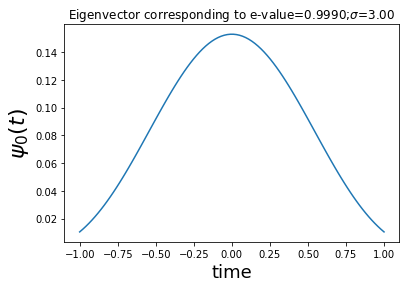

In [20]:
sigma = 3
w, v = np.linalg.eigh(kernel(t-t[:, None], sigma))
maxv = v[:, w.argmax()]
fig, ax = plt.subplots()
ax.plot(t, maxv)
ax.set_xlabel('time', fontsize=18)
ax.set_ylabel('$\psi_0(t)$', fontsize=22)
ax.set_title('Eigenvector corresponding to e-value=%3.4f;$\sigma$=%3.2f'%(w.max()*dt, sigma))

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Note that we'll see this shape again when we take up window functions.

What does this all mean? By framing our problem this way, we made a connection between the quality of our reconstruction via the Whittaker interpolant and the time-bandwidth product. Up until now, we did not have a concrete way of relating limitations in time to limitations in frequency. Now that we know how to use the time-bandwidth product, let's go back to the original formulation with the separate  $\tau$ and $W$ terms as in the following:

$$ \int_{-\tau}^\tau \phi(x)\frac{\sin(2\pi W (t-x))}{\pi(t-x)} dx = \lambda \phi(t)$$

and then re-solve the eigenvalue problem.

Text(0.5, 1.0, '$\\sigma=5$')

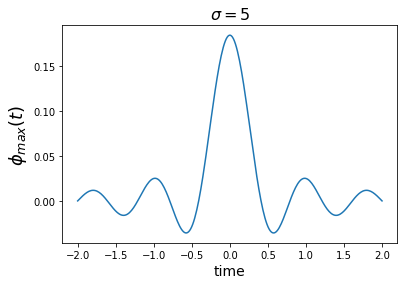

In [24]:
def kernel_tau(x,W=1):
    'convenient function to compute kernel of eigenvalue problem'
    x = np.asanyarray(x)
    y = np.pi*np.where(x == 0,1.0e-20, x)
    return np.sin(2*W*y)/y

nstep = 300                     # quick and dirty integral quantization
t = np.linspace(-1,1, nstep)    # quantization of time
tt = np.linspace(-2,2, nstep)   # extend interval

sigma = 5
W = sigma/2./2./t.max()

w,v = np.linalg.eig(kernel_tau(t-tt[:,None],W))
ii = np.argsort(w.real) 
maxv = v[:, w.real.argmax()].real
fig,ax = plt.subplots()
ax.plot(tt, maxv/np.sign(maxv[nstep//2])) # normalize to keep orientation upwards
ax.set_xlabel('time',fontsize=14)
ax.set_ylabel(r'$\phi_{max}(t)$',fontsize=18)
ax.set_title('$\sigma=%d$'%(2*W*2*t.max()),fontsize=16)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

$\DeclareMathOperator{\sinc}{sinc}$

This looks suspicously like the $\sinc$ function. In fact, in the limit as $\sigma \rightarrow \infty$, the  eigenfunctions devolve into time-shifted versions of the $\sinc$ function. These are the same functions used in the Whittaker interpolant. Now we have a way to justify the interpolant by appealing to large $\sigma$ values.

## Summary

In this section, at first blush, it may look like we accomplished nothing. We started out investigating why is it that we have some residual error in the reconstruction formula using the Whittaker approximation functions. Then, we recognized that we cannot have signals that are simultaneously time-limited and band-limited. This realization drove us to investigate "approximately" time-limited functions. Through carefully examining the resulting eigenvalue problem, we determined the time-bandwidth conditions under which the
Whittaker interopolant is asymptotically valid. As you can imagine, there is much more to this story and many powerful theorems place bounds on the quality and dimensionality of this reconstruction, but for us, the qualifying concept of time-bandwidth product is enough for now.


## References


* This is in the [IPython Notebook format](http://ipython.org/) and was converted to HTML using [nbconvert](https://github.com/ipython/nbconvert).

* See [Signal analysis](http://books.google.com/books?id=Re5SAAAAMAAJ) for more detailed mathematical development.

* The IPython notebook corresponding to this post can be found [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Sampling_Theorem_Part_2.ipynb).

In [7]:
%qtconsole

D:\Miniconda64\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
